In [1]:
%load_ext autoreload
%autoreload 2

# Training Convnets

![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/convnets/blob/master/learn/02_training_convnets.ipynb)

When training convnets a lot of things can go wrong. And even if everything seems to work fine, you might not be getting the most out of your model. In this notbook we present a few tips and tricks that will help you get the most out of your convnets.

## Data exploration

It is a good idea to explore your data before training any convnet to answer questions such as:

- What type of problem are you trying to solve? Is it a binary classification problem, a multiclass classification problem, a multilabel classification problem, a regression problem, or something else (object detection, segmentation, image generation, ...)? 
- How many samples are there in the dataset?
- In the case of classification, what is the distribution of classes in the training, validation and test sets?

When working with images for computer vision applications, it is also interesting to visualize some samples, check the number of channels (gray scale, RGB, ...), the size of the images, statistics such as maximum and minimum values, data types, etc.

For this example we will use the CIFAR10 dataset.


In [2]:
import torchvision

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

len(trainset), len(testset)

/home/juan/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

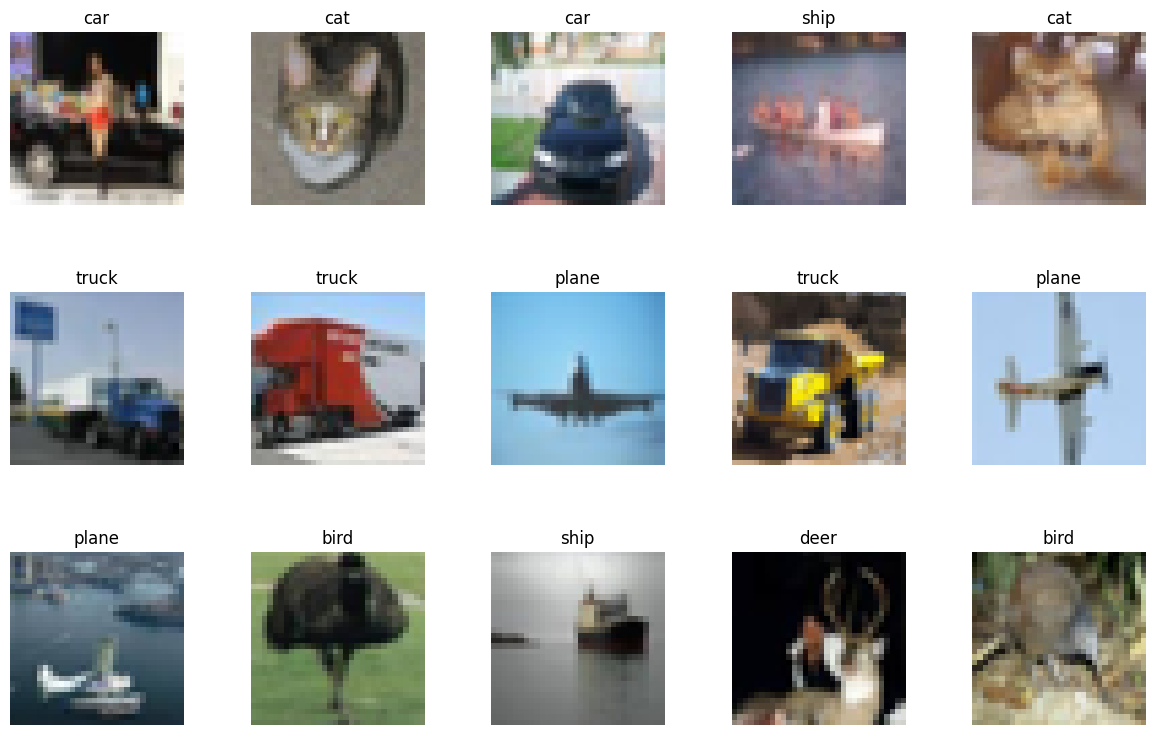

In [3]:
import random
import matplotlib.pyplot as plt

r, c = 3, 5
plt.figure(figsize=(c*3, r*3))
for row in range(r):
    for col in range(c):
        index = c*row + col
        plt.subplot(r, c, index + 1)
        ix = random.randint(0, len(trainset)-1)
        img, label = trainset[ix]
        plt.imshow(img)
        plt.axis('off')
        plt.title(classes[label])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

We convert the images to numpy arrays to get statistics.

In [4]:
import numpy as np

train_images = np.array([np.array(img) for img, label in trainset])
test_images = np.array([np.array(img) for img, label in testset])

train_labels = np.array([label for img, label in trainset])
test_labels = np.array([label for img, label in testset])

In [5]:
train_images.shape, test_images.shape, train_labels.shape, test_labels.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000,), (10000,))

In [6]:
train_images.dtype, train_labels.dtype

(dtype('uint8'), dtype('int64'))

In [7]:
max_value = train_images.max(axis=(0, 1, 2))
min_value = train_images.min(axis=(0, 1, 2))

max_value, min_value

(array([255, 255, 255], dtype=uint8), array([0, 0, 0], dtype=uint8))

In [8]:
mean = (train_images / 255).mean(axis=(0, 1, 2))
std = (train_images / 255).std(axis=(0, 1, 2))

mean, std

(array([0.49139968, 0.48215841, 0.44653091]),
 array([0.24703223, 0.24348513, 0.26158784]))

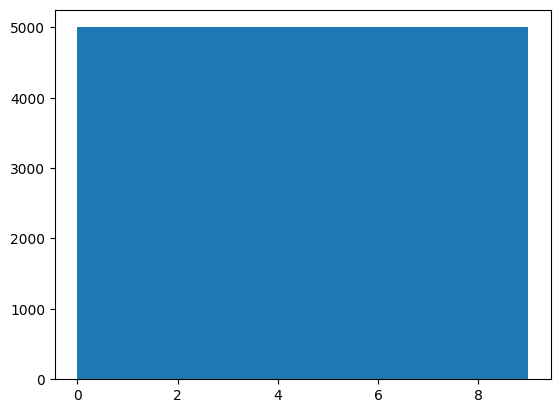

In [9]:
# class distribution

plt.hist(train_labels, bins=len(classes))
plt.show()

In [10]:
unique, counts = np.unique(train_labels, return_counts=True)
unique, counts

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))

In this particular case we have the same number of samples for each class, but this is not usually the case.

## Debugging the model

While developing a new model it is a good idea to pass one batch of random values and check that the output of the model is what we expect. You can also place `print` statements in the model to check the values of the tensors at different points in the model.

In [26]:
import torch 
from convnets.models.lenet5 import block

class LeNet5(torch.nn.Module):
  def __init__(self, n_channels=3, n_outputs=10):
    super().__init__()
    self.conv1 = block(n_channels, 6)
    self.conv2 = block(6, 16)
    self.conv3 = torch.nn.Sequential(
        torch.nn.Conv2d(16, 120, 5, padding=0),
        torch.nn.Tanh()
    )
    self.fc1 = torch.nn.Sequential(
        torch.nn.Linear(120, 84),
        torch.nn.Tanh()
    )
    self.fc2 = torch.nn.Linear(84, 10)

  def forward(self, x):
    print(x.shape)
    x = self.conv1(x)
    print(x.shape)
    x = self.conv2(x)
    print(x.shape)
    x = self.conv3(x)
    print(x.shape)
    x = x.view(x.shape[0], -1)
    print(x.shape)
    x = self.fc1(x)
    print(x.shape)
    x = self.fc2(x)
    return x

In [27]:
model = LeNet5()
outputs = model(torch.randn(1, 3, 32, 32))
outputs.shape

torch.Size([1, 3, 32, 32])
torch.Size([1, 6, 14, 14])
torch.Size([1, 16, 5, 5])
torch.Size([1, 120, 1, 1])
torch.Size([1, 120])
torch.Size([1, 84])


torch.Size([1, 10])

### Fitting one batch

Before training the model with all the data, it is a good idea to fit one batch to check that it is working as expected. This is a good way to debug the model alongside the optimizer, metrics and loss function. If everything works fine, the models should "memorize" the batch of data and the loss should go to zero.

In [28]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)

# make sure to set shuffle=False !!!
dataloaders = {
    'train': torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=False),
}

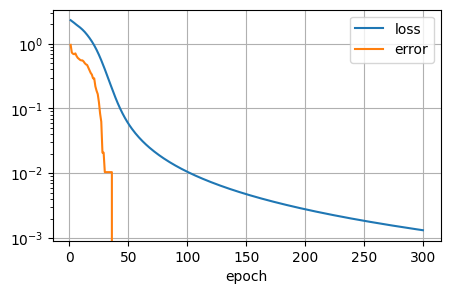

In [29]:
from convnets.train import fit 
from convnets.models import LeNet5
import pandas as pd

model = LeNet5(in_channels=3, n_classes=10)
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

hist = fit(model, dataloaders, optimizer, criterion, 'cuda', overfit=1, log=False, epochs=300)

df = pd.DataFrame(hist)
df.plot(x='epoch', y=['loss', 'error'], grid=True, figsize=(5, 3), logy=True)
plt.show()

## Training the model

Now that we are pretty sure that our model works properly is time to train it. Since you will probably train your model a bunch of times it is important to take the following things into account:

1. Fix the random seed for reproducibility (if not you'll get different results even if you don't change anything).
2. Use a validation set to monitor the training (and compare models).
3. Start simple and then add complexity (one thing at a time).

In [30]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)


In [33]:
from convnets.train import seed_everything

seed_everything()

dataloaders = {
    'train': torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=10, pin_memory=True),
    'test': torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False, num_workers=10, pin_memory=True),
}

model = LeNet5(in_channels=3, n_classes=10)
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

hist = fit(model, dataloaders, optimizer, criterion, 'cuda', epochs=50)

Training model on cuda


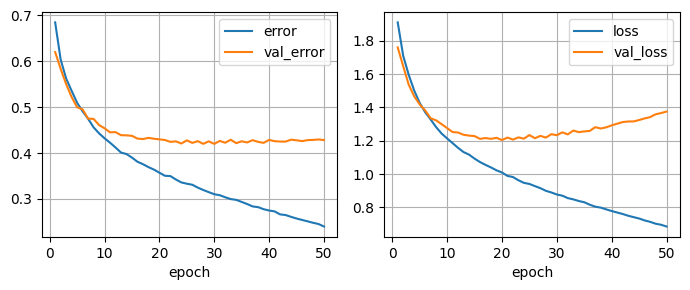

In [34]:
df = pd.DataFrame(hist)
fig = plt.figure(figsize=(7,3))
ax = plt.subplot(1, 2, 1)
df.plot(x='epoch', y=['error', 'val_error'], ax = ax)
ax.grid(True)
ax = plt.subplot(1, 2, 2)
df.plot(x='epoch', y=['loss', 'val_loss'], ax = ax)
ax.grid(True)
plt.tight_layout()
plt.show()

The previous image shows the learning curves of our training process. We can see that the training loss decreases while the validation loss starts decreasing but then increases. This is a clear sign of **overfitting** (and this is what you want to see in your model at first).

## Regularization

To reduce overfitting we can use different techniques such as:

- **Get more data** (if possible).
- **Data augmentation**: generate more training data from existing training samples, by augmenting the samples via a number of random transformations. 
- **Activations normalization**: normalize the activations of the previous layer with batch normalization, for example.
- **Dropout**: randomly set a fraction rate of input units to 0 at each update during training time, which helps prevent overfitting.
- **Weight decay**: add a cost associated with the absolute value of the magnitude of coefficients in the model in order to reduce overfitting.
- **Early stopping**: stop training when the validation loss is no longer improving.
- **Try larger models**: even though though larger models will overffit more, their early stoped performance can be better.

Let's augment our dataset with some random flips and crops.

In [35]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(32),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)

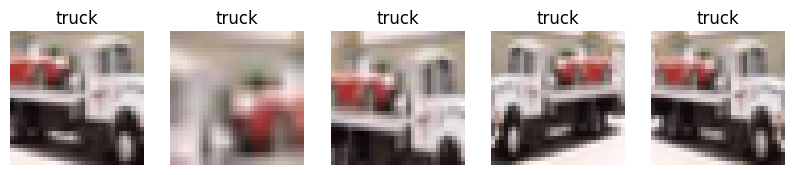

In [36]:
fig = plt.figure(figsize=(10, 10))
r, c = 1, 5
sample = random.randint(0, len(trainset))
for i in range(r * c):
  ax = plt.subplot(r, c, i + 1)
  ax.imshow(trainset[sample][0])
  ax.set_title(classes[trainset[sample][1]])
  ax.axis('off')
plt.show()


For early stopping we will save the best model during and restore it at the end (you can optionaly stop training after some epochs without improving, although in practice it is often a good idea to just let the model train until the end, you may be surprised!).

In [38]:
import os 

seed_everything()

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(32),
	transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]))

# do not apply data augmentation to test !
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]))

dataloaders = {
    'train': torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=10, pin_memory=True),
    'test': torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False, num_workers=10, pin_memory=True),
}

model = LeNet5(in_channels=3, n_classes=10)
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

class on_epoch_end:
	best_error = 1
	ckpt_path = None

	def __call__(self, hist, model, *args):
		val_error = hist['val_error'][-1]
		epoch = hist['epoch'][-1]
		if val_error < self.best_error:	
			if self.ckpt_path is not None:
				os.remove(self.ckpt_path)
			self.ckpt_path = f'./checkpoints/model_{val_error:.5f}_{epoch}.pth'
			torch.save(model.state_dict(), self.ckpt_path)
			best_error = val_error
			# print(f'Saved new best model with val_error {val_error:.5f}')

hist = fit(model, dataloaders, optimizer, criterion, 'cuda', epochs=50, on_epoch_end=on_epoch_end())

Training model on cuda


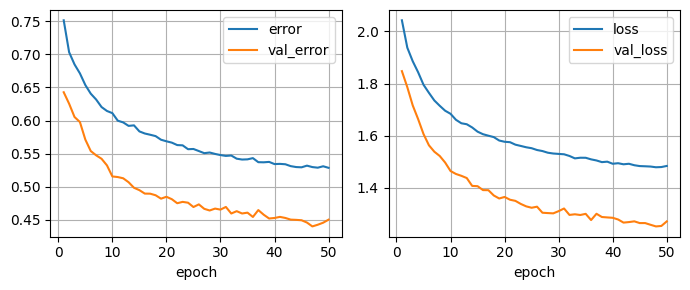

In [39]:
df = pd.DataFrame(hist)
fig = plt.figure(figsize=(7,3))
ax = plt.subplot(1, 2, 1)
df.plot(x='epoch', y=['error', 'val_error'], ax = ax)
ax.grid(True)
ax = plt.subplot(1, 2, 2)
df.plot(x='epoch', y=['loss', 'val_loss'], ax = ax)
ax.grid(True)
plt.tight_layout()
plt.show()

Now both learning curves decrease during all training (and we should in fact train longer until the validation error stops improving). 

Now we can load our best model

In [40]:
models = os.listdir('./checkpoints')
models

['model_0.45004_50.pth', 'model_0.44994_50.pth', 'model_0.56190_10.pth']

In [41]:
model.load_state_dict(torch.load(f'./checkpoints/{models[0]}')) 

<All keys matched successfully>

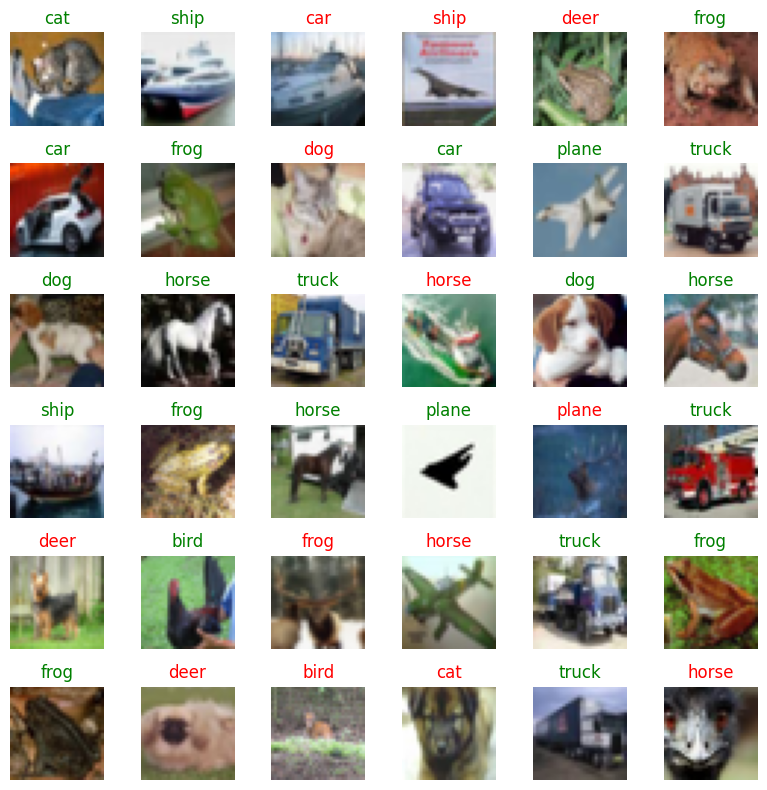

In [44]:
r, c = 6, 6

fig = plt.figure(figsize=(8, 8))
for i in range(r * c):
	ax = plt.subplot(r, c, i + 1)
	ax.imshow(testset[i][0].permute(1, 2, 0) * 0.5 + 0.5)
	pred = classes[model(testset[i][0].unsqueeze(0).cuda()).argmax().item()]
	gt = classes[testset[i][1]]
	ax.set_title(pred, color="red" if pred != gt else "green")
	ax.axis('off')
plt.tight_layout()
plt.show()

These are the most effective regularization techniques for convnets, while normaliztion and dropout will depend on the model and weight decay on the optimizer.

## Transfer Learning

Unless you are training with a massive dataset, you will probably always get the best results by using a pretrained model. Large models pretrained on ImageNet are available from different sources (such as torchvision or timm) and ready to use. Learn mode about transfer learning in this [notebook](03_transfer_learning.ipynb)

## Hyperparameter tuning

The final step consists in tuning the hyperparameters of the model. This is a very time consuming task, so you may want to run it over night or during a weekedn, but it is very important to get the best results. To accelerate the process you can use a subset of the training data (10-20%) and run the optimization process in parallel. 

In this notebook we will use the [Optuna](https://optuna.org/) library to tune the hyperparameters of our model, starting with the learning rate and the batch size. You can use the optuna dashboard to monitor the progress of the optimization.

In [25]:
import optuna

def objective(trial):
    # Suggest values of the hyperparameters using a trial object.
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256, 512])
    seed_everything()
    dataloaders = {
        'train': torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=10, pin_memory=True),
        'test': torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=10, pin_memory=True),
    }
    model = LeNet5(in_channels=3, n_classes=10)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    print("batch_size:", batch_size, "lr:", lr)
    hist = fit(model, dataloaders, optimizer, criterion, 'cuda', epochs=10, log=False, limit_train_batches=100)
    return hist['val_error'][-1]

study = optuna.create_study(direction='minimize', storage="sqlite:///db.sqlite3",  study_name="lenet5")
study.optimize(objective, n_trials=10)

[I 2023-01-14 10:06:45,822] A new study created in RDB with name: lenet5


batch_size: 64 lr: 2.0590982514806107e-05


[I 2023-01-14 10:07:01,770] Trial 0 finished with value: 0.7363654458598726 and parameters: {'lr': 2.0590982514806107e-05, 'batch_size': 64}. Best is trial 0 with value: 0.7363654458598726.


batch_size: 256 lr: 0.0001602988828961182


[I 2023-01-14 10:07:25,315] Trial 1 finished with value: 0.62294921875 and parameters: {'lr': 0.0001602988828961182, 'batch_size': 256}. Best is trial 1 with value: 0.62294921875.


batch_size: 128 lr: 0.019954272707172854


[I 2023-01-14 10:07:43,674] Trial 2 finished with value: 0.7511867088607594 and parameters: {'lr': 0.019954272707172854, 'batch_size': 128}. Best is trial 1 with value: 0.62294921875.


batch_size: 64 lr: 0.0069917907172964205


[I 2023-01-14 10:07:59,671] Trial 3 finished with value: 0.6606289808917197 and parameters: {'lr': 0.0069917907172964205, 'batch_size': 64}. Best is trial 1 with value: 0.62294921875.


batch_size: 512 lr: 2.524912193684328e-05


[I 2023-01-14 10:08:33,040] Trial 4 finished with value: 0.6827090992647059 and parameters: {'lr': 2.524912193684328e-05, 'batch_size': 512}. Best is trial 1 with value: 0.62294921875.


batch_size: 64 lr: 0.00026517468715239956


[I 2023-01-14 10:08:49,000] Trial 5 finished with value: 0.6348527070063694 and parameters: {'lr': 0.00026517468715239956, 'batch_size': 64}. Best is trial 1 with value: 0.62294921875.


batch_size: 512 lr: 0.0011040684088348292


[I 2023-01-14 10:09:24,618] Trial 6 finished with value: 0.5158662683823529 and parameters: {'lr': 0.0011040684088348292, 'batch_size': 512}. Best is trial 6 with value: 0.5158662683823529.


batch_size: 256 lr: 0.018089523781938108


[I 2023-01-14 10:09:48,494] Trial 7 finished with value: 0.64169921875 and parameters: {'lr': 0.018089523781938108, 'batch_size': 256}. Best is trial 6 with value: 0.5158662683823529.


batch_size: 64 lr: 5.159154761705489e-05


[I 2023-01-14 10:10:04,354] Trial 8 finished with value: 0.677547770700637 and parameters: {'lr': 5.159154761705489e-05, 'batch_size': 64}. Best is trial 6 with value: 0.5158662683823529.


batch_size: 512 lr: 0.002818720446579101


[I 2023-01-14 10:10:37,992] Trial 9 finished with value: 0.5022633272058823 and parameters: {'lr': 0.002818720446579101, 'batch_size': 512}. Best is trial 9 with value: 0.5022633272058823.
